# 基于PyTorch应用图片迁移学习分类任务

主要学习内容：
- 熟悉交通标志图像数据集
- 构建数据集
- 基于Torchvision引入预训练模型
- 添加新的未知类别然后重新训练模型

来源：
- 文章：[Transfer Learning for Image Classification using Torchvision, Pytorch and Python](https://curiousily.com/posts/transfer-learning-for-image-classification-using-torchvision-pytorch-and-python/)

In [3]:
!pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 49.9 MB 693 kB/s eta 0:00:01


In [2]:
# 下载数据集
# !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P ./data/
# !unzip -qq GTSRB_Final_Training_Images.zip

In [1]:
import shutil
from collections import defaultdict
from glob import glob
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#93D30C",
    "#8F00FF",
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams["figure.figsize"] = 12, 8

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 数据处理

In [4]:
train_folders = sorted(glob("./data/GTSRB/Final_Training/Images/*"))

In [5]:
len(train_folders)

43

In [6]:
# 利用 OpenCV 和 Torchvision 加载和显示图片
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    return img


def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis("off")


def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")

In [7]:
sample_images = [np.random.choice(glob(f"{tf}/*ppm")) for tf in train_folders]

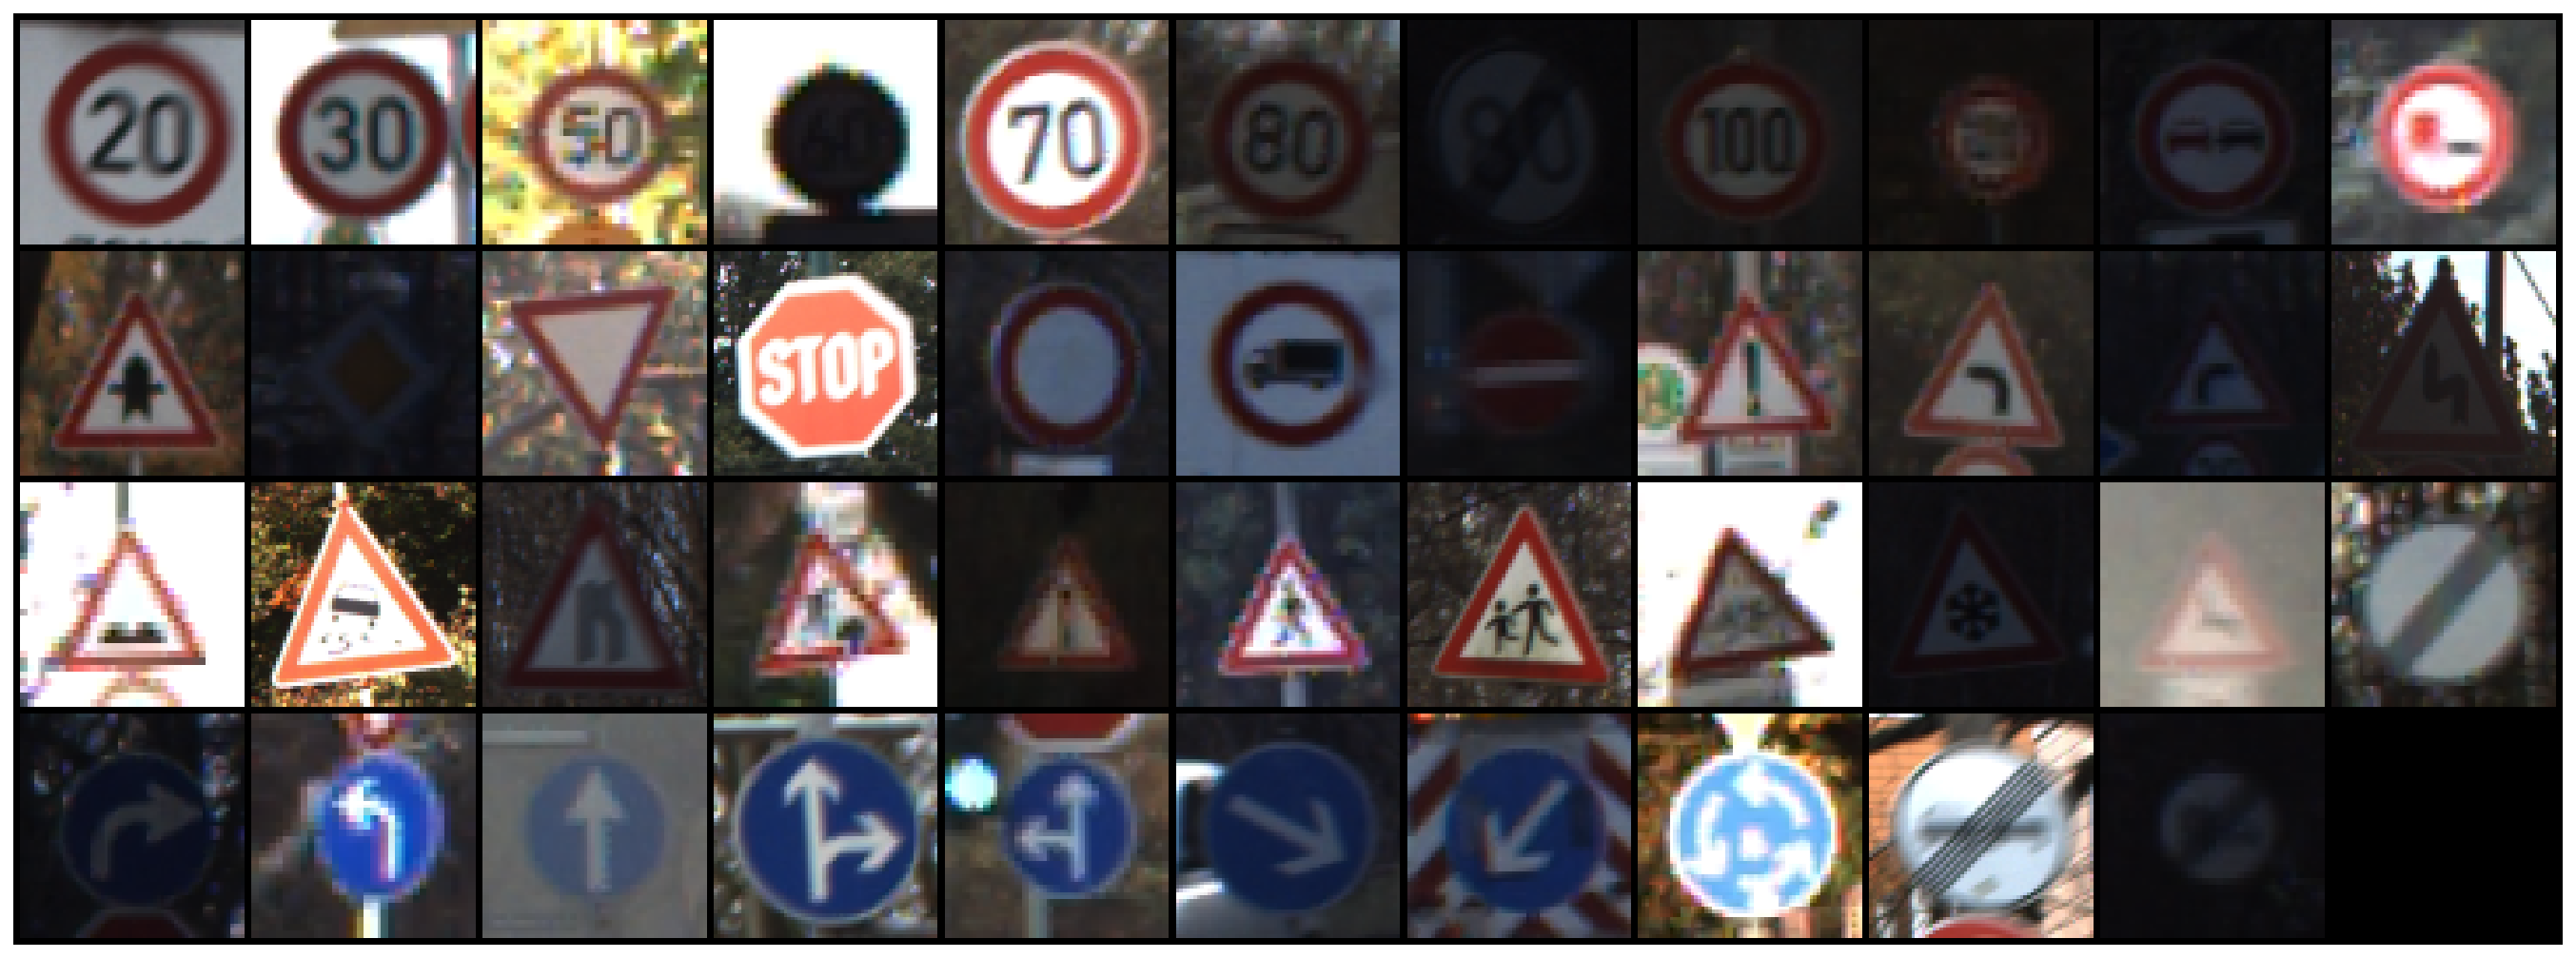

In [8]:
show_sign_grid(sample_images)

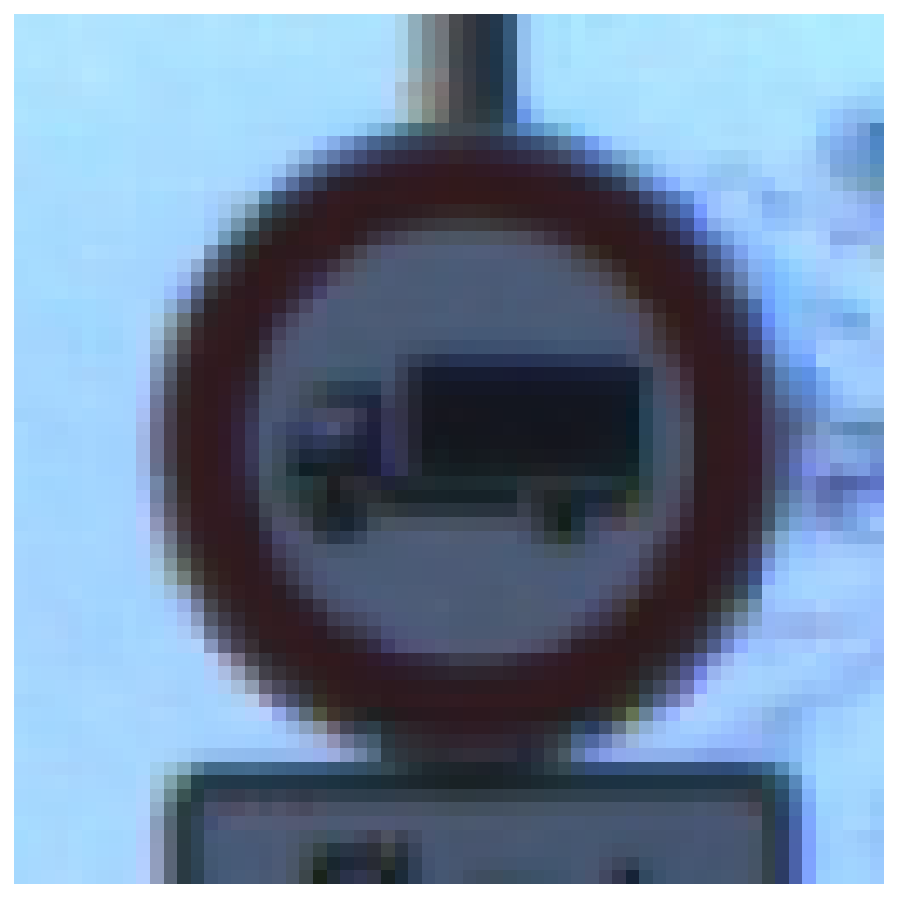

In [9]:
img_path = glob(f"{train_folders[16]}/*ppm")[1]
show_image(img_path)

In [10]:
class_names = ["priority_road", "give_way", "stop", "no_entry"]
class_indices = [12, 13, 14, 17]

In [11]:
DATA_DIR = Path("./data/GTSRB/data")

In [12]:
DATASETS = ["train", "val", "test"]
for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [13]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f"{train_folders[cls_index]}/*.ppm"))
    class_name = class_names[i]
    print(f"{class_name}: {len(image_paths)}")
    np.random.shuffle(image_paths)
    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(0.8 * len(image_paths)), int(0.9 * len(image_paths))],
    )
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f"{DATA_DIR}/{ds}/{class_name}/")

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [14]:
# 人为增加训练集
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {
    "train": T.Compose(
        [
            T.RandomResizedCrop(size=256),
            T.RandomRotation(degrees=15),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(mean_nums, std_nums),
        ]
    ),
    "val": T.Compose(
        [
            T.Resize(size=256),
            T.CenterCrop(size=224),
            T.ToTensor(),
            T.Normalize(mean_nums, std_nums),
        ]
    ),
    "test": T.Compose(
        [
            T.Resize(size=256),
            T.CenterCrop(size=224),
            T.ToTensor(),
            T.Normalize(mean_nums, std_nums),
        ]
    ),
}

In [15]:
image_datasets = {d: ImageFolder(f"{DATA_DIR}/{d}", transforms[d]) for d in DATASETS}
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
    for d in DATASETS
}

In [16]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets["train"].classes
dataset_sizes, class_names

({'train': 5914, 'val': 1174, 'test': 1177},
 ['give_way', 'no_entry', 'priority_road', 'stop'])

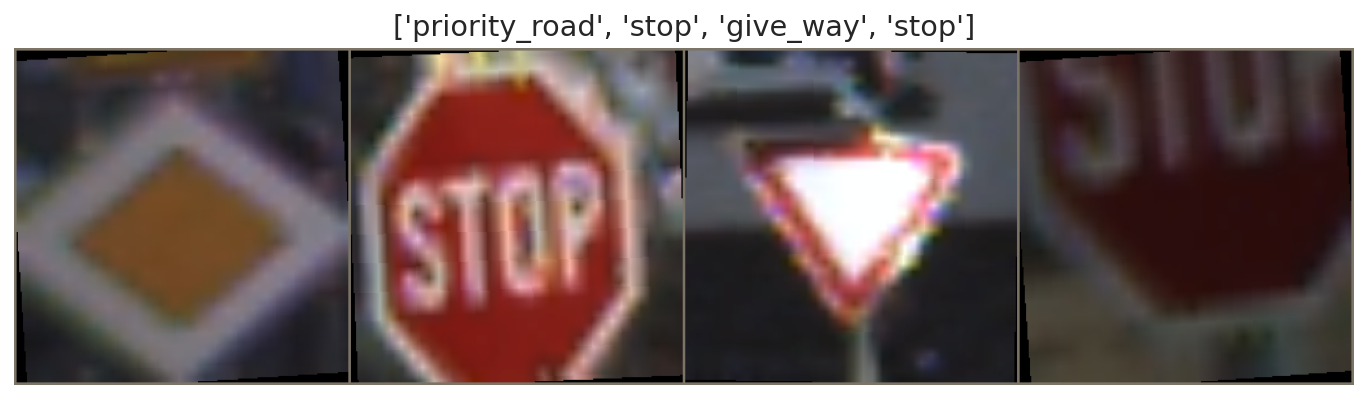

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")


inputs, classes = next(iter(data_loaders["train"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## 预训练

In [18]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)
    n_features = model.fc.in_features
    print(n_features)
    model.fc = nn.Linear(n_features, n_classes)
    return model.to(device)

In [19]:
class_names

['give_way', 'no_entry', 'priority_road', 'stop']

In [20]:
base_model = create_model(len(class_names))

512


## 训练

In [22]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print("-" * 10)
        train_acc, train_loss = train_epoch(
            model,
            data_loaders["train"],
            loss_fn,
            optimizer,
            device,
            scheduler,
            dataset_sizes["train"],
        )
        print(f"Train loss {train_loss} accuracy {train_acc}")
        val_acc, val_loss = eval_model(
            model, data_loaders["val"], loss_fn, device, dataset_sizes["val"]
        )
        print(f"Val   loss {val_loss} accuracy {val_acc}")
        print()
        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), "best_model_state.bin")
            best_accuracy = val_acc
    print(f"Best val accuracy: {best_accuracy}")
    model.load_state_dict(torch.load("best_model_state.bin"))
    return model, history

In [24]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.30547004086066204 accuracy 0.8975312817044301
Val   loss 0.012582540039209587 accuracy 0.9974446337308348

Epoch 2/3
----------
Train loss 0.11024861666872747 accuracy 0.9656746702739263
Val   loss 0.010265339052316674 accuracy 0.9940374787052811

Epoch 3/3
----------
Train loss 0.06146008469073469 accuracy 0.9788637132228609
Val   loss 0.0009371871151980256 accuracy 0.9991482112436116

Best val accuracy: 0.9991482112436116
CPU times: user 1min 52s, sys: 2.96 s, total: 1min 55s
Wall time: 1min 56s


In [31]:
history["val_loss"]

[0.012582540039209587, 0.010265339052316674, 0.0009371871151980256]

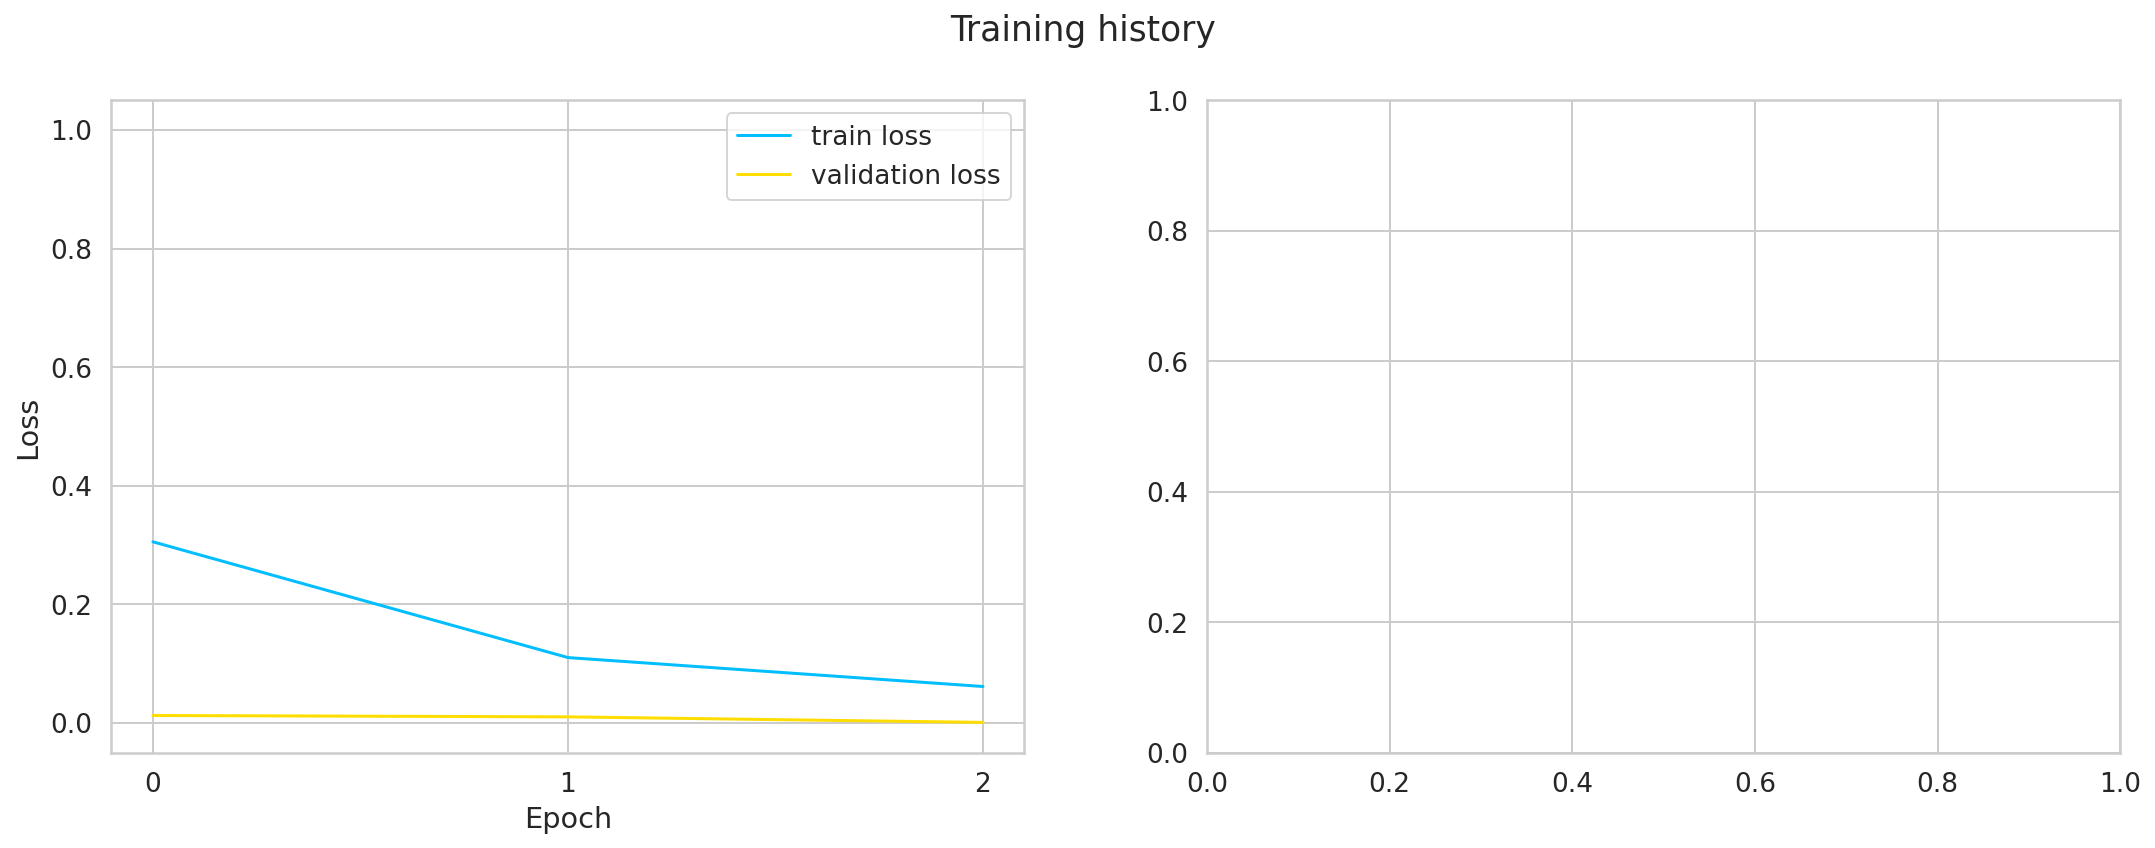

In [33]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history["train_loss"], label="train loss")
    ax1.plot(history["val_loss"], label="validation loss")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax2.plot(history["train_acc"], label="train accuracy")
    ax2.plot(history["val_acc"], label="validation accuracy")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")
    fig.suptitle("Training history")


plot_training_history(history)

## 预测

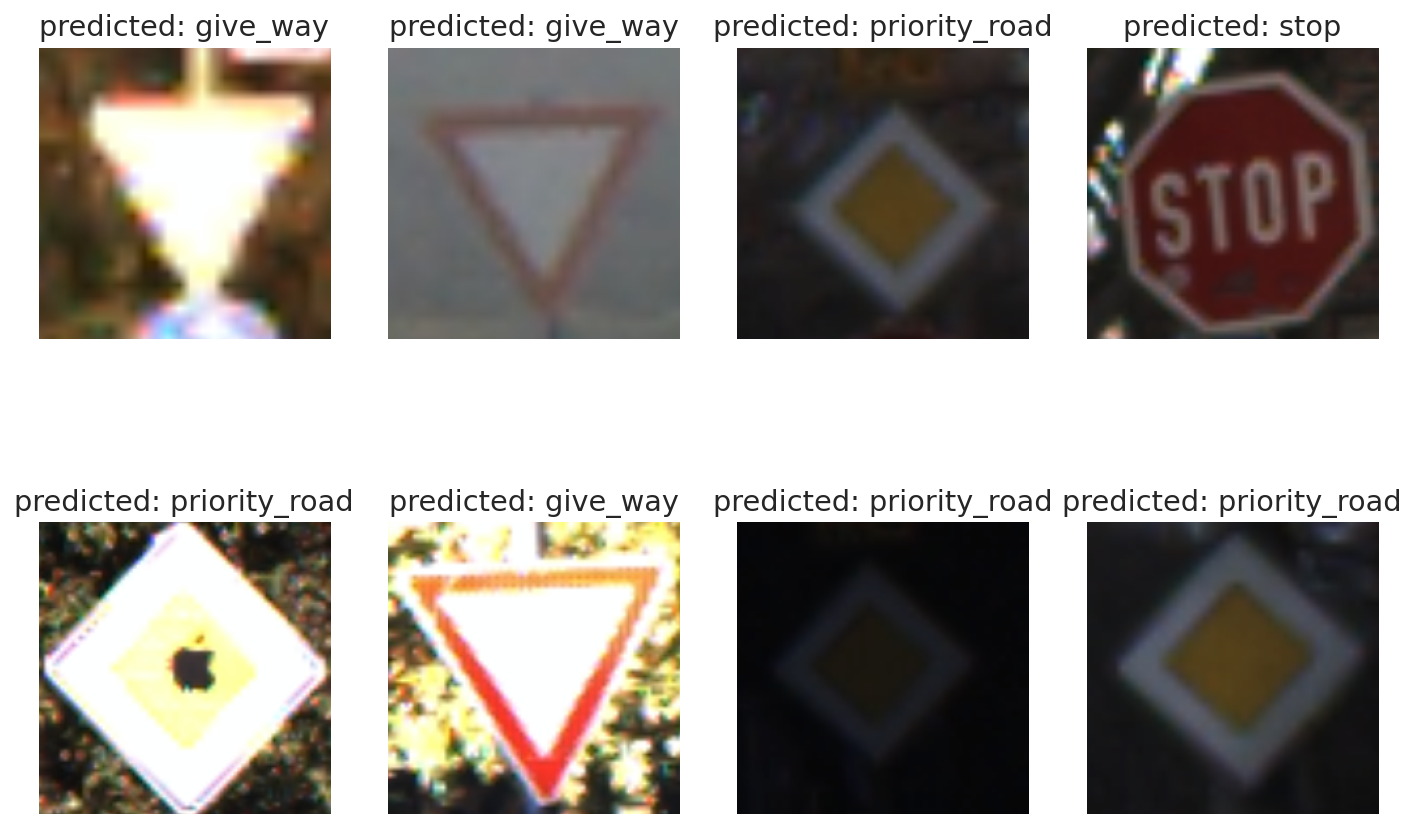

In [34]:
def show_predictions(model, class_names, n_images=6):
    model = model.eval()
    images_handeled = 0
    plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images // 2, images_handeled)
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])
                ax.axis("off")
                if images_handeled == n_images:
                    return


show_predictions(base_model, class_names, n_images=8)